## EJERCICIO 1: Elección del dataset

Para esta práctica, se ha seleccionado un conjunto de datos extraído de Kaggle, titulado "Plant Disease Recognition Dataset", creado por Rashik Rahman Pritom. Este conjunto de datos se encuentra disponible en el siguiente enlace: https://www.kaggle.com/datasets/rashikrahmanpritom/plant-disease-recognition-dataset.
Disponemos de tres tipos de hojas: Healthy, Rust y Powdery. Para cada clase tenemos una carpeta train y otra test. Disponemos de aproximadamente 400 datos para cada clase, aunque usaremos unos 200.

In [86]:
import os
import cv2
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold, GridSearchCV
import random


PATH_POSITIVE_TRAIN = "data_plantas/Train/Train/Rust/"
PATH_NEGATIVE_TRAIN = "data_plantas/Train/Train/Healthy/"
PATH_POSITIVE_TEST = "data_plantas/Test/Test/Rust/"
PATH_NEGATIVE_TEST = "data_plantas/Test/Test/Healthy/"
IMAGE_EXTENSION = ".jpg"
  
def load_training_data_HOG():
    """
    Lee las imágenes de entrenamiento (positivas y negativas) y calcula sus
    descriptores para el entrenamiento.

    returns:
    np.array: numpy array con los descriptores de las imágenes leídas
    np.array: numpy array con las etiquetas de las imágenes leídas
    """ 
    training_data = []
    classes = []    
    fixed_size = (128, 256)
    random.seed(42)  # Semilla para reproducibilidad

    #Seleccionamos solo 200 imágenes positivas para que no tarde mucho el SVM
    positive_files = [f for f in os.listdir(PATH_POSITIVE_TRAIN) if f.endswith(IMAGE_EXTENSION)]
    selected_positive_files = random.sample(positive_files, min(200, len(positive_files)))

    # Casos positivos
    for filename in selected_positive_files:
        filepath = os.path.join(PATH_POSITIVE_TRAIN, filename)
        img = cv2.imread(filepath)
        img = cv2.resize(img, fixed_size)
        hog = cv2.HOGDescriptor()
        descriptor = hog.compute(img)
        training_data.append(descriptor.flatten())  #Convirtimos a 1D para consistencia
        classes.append(1)

    print(f"Leídas {len(selected_positive_files)} imágenes de TRAIN -> positivas")


     # Seleccionar 200 imágenes negativas
    negative_files = [f for f in os.listdir(PATH_NEGATIVE_TRAIN) if f.endswith(IMAGE_EXTENSION)]
    selected_negative_files = random.sample(negative_files, min(200, len(negative_files)))

    # Casos negativos
    for filename in selected_negative_files:
        filepath = os.path.join(PATH_NEGATIVE_TRAIN, filename)
        img = cv2.imread(filepath)
        img = cv2.resize(img, fixed_size)
        hog = cv2.HOGDescriptor()
        descriptor = hog.compute(img)
        training_data.append(descriptor.flatten())  # Convertir a 1D
        classes.append(0)

    print(f"Leídas {len(selected_negative_files)} imágenes de TRAIN -> negativas")


    return np.array(training_data), np.array(classes)

def load_testing_data_HOG():
    """
    Lee las imágenes de test (positivas y negativas) y calcula sus
    descriptores para la fase de prueba.

    returns:
    np.array: numpy array con los descriptores de las imágenes leídas
    np.array: numpy array con las etiquetas de las imágenes leídas
    """ 
    testing_data = []
    classes = []    
    fixed_size = (128, 256)
    random.seed(42)  # Semilla para reproducibilidad

    #Seleccionamos solo 40 imágenes positivas para que no tarde mucho el SVM
    positive_files = [f for f in os.listdir(PATH_POSITIVE_TEST) if f.endswith(IMAGE_EXTENSION)]
    selected_positive_files = random.sample(positive_files, min(50, len(positive_files)))

    # Casos positivos
    for filename in selected_positive_files:
        filepath = os.path.join(PATH_POSITIVE_TEST, filename)
        img = cv2.imread(filepath)
        img = cv2.resize(img, fixed_size)
        hog = cv2.HOGDescriptor()
        descriptor = hog.compute(img)
        testing_data.append(descriptor.flatten())  #Convirtimos a 1D para consistencia
        classes.append(1)

    print(f"Leídas {len(selected_positive_files)} imágenes de TEST -> positivas")


     # Seleccionar 40 imágenes negativas
    negative_files = [f for f in os.listdir(PATH_NEGATIVE_TEST) if f.endswith(IMAGE_EXTENSION)]
    selected_negative_files = random.sample(negative_files, min(50, len(negative_files)))

    # Casos negativos
    for filename in selected_negative_files:
        filepath = os.path.join(PATH_NEGATIVE_TEST, filename)
        img = cv2.imread(filepath)
        img = cv2.resize(img, fixed_size)
        hog = cv2.HOGDescriptor()
        descriptor = hog.compute(img)
        testing_data.append(descriptor.flatten())  # Convertir a 1D
        classes.append(0)

    print(f"Leídas {len(selected_negative_files)} imágenes de TEST -> negativas")

    return np.array(testing_data), np.array(classes)
 

def train(training_data, classes):
    """
    Entrena el clasificador utilizando scikit-learn.

    Parameters:
    training_data (np.array): datos de entrenamiento
    classes (np.array): clases asociadas a los datos de entrenamiento

    Returns:
    SVC: un clasificador SVM entrenado
    """
    # Inicializa el clasificador SVM
    svm = SVC(kernel='linear', C=1.0, random_state=42)

    # Entrena el clasificador
    svm.fit(training_data, classes)

    return svm


def test(image, clasificador):
    """
    Clasifica la imagen pasada por parámetro
    
    Parameters:
    image (np.array): imagen a clasificar
    clasificador (cv2.SVM): clasificador
    
    Returns:
        int: clase a la que pertenece la imagen (1|0) 
    """
    # HOG de la imagen a testear
    #hog = cv2.HOGDescriptor()
    #descriptor = hog.compute(image)
    descriptor=image
    # Clasificación
    # Devuelve una tupla donde el segundo elemento es un array 
    # que contiene las predicciones (en nuestro caso solo una)
    # ej: (0.0, array([[1.]], dtype=float32))
    return clasificador.predict(descriptor.reshape(1, -1))[0]
    #return int(clasificador.predict(descriptor.reshape(1, -1))[1][0][0])

In [3]:
#X_train, X_test, y_train, y_test= load_and_split_data()
X_train, y_train= load_training_data_HOG()

Leídas 200 imágenes de TRAIN -> positivas
Leídas 200 imágenes de TRAIN -> negativas


In [4]:
X_test, y_test= load_testing_data_HOG()

Leídas 50 imágenes de TEST -> positivas
Leídas 50 imágenes de TEST -> negativas


## EJERCICIO 3: Clasificación usando HOG

### Mejora 1: Medir la bondad del clasificador

In [8]:
#Mejora 1: Leemos las imágenes train y test (definimos nueva función load_testing_data()), 
#entrenamos el clasificador SVM y testeamos para todos los ejemplos test. Mostramos la matriz de confusión y otras medidas
    
def clasificador_imagenes(X_train, X_test, y_train, y_test):
    """
    Prueba de entrenamiento de un clasificador
    """       
    # Entrenamos el clasificador (SVM)
    clasificador = train(X_train, y_train)
    print("Clasificador entrenado")  
    
    
    predictions = [] #Almacenamos las predicciones
    
    for i, descriptor in enumerate(X_test): 
        prediction = test(descriptor, clasificador)
        predictions.append(prediction)

    #Calculamos la precisión
    correct_predictions = np.sum(predictions == y_test)
    total_samples = len(y_test)
    print(f"\nImágenes correctamente clasificadas: {correct_predictions}/{total_samples}")
    print(f"Precisión total: {(correct_predictions / total_samples) * 100:.2f}%")
    
    #Mostramos la matriz de confusión
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negativo", "Positivo"], yticklabels=["Negativo", "Positivo"])
    plt.xlabel("Clase predicha")
    plt.ylabel("Clase real")
    plt.title("Matriz de Confusión")
    plt.show()

    #Mostramos un informe detallado con las medidas de la bondad del clasificador
    report = classification_report(y_test, predictions, target_names=["Negativo", "Positivo"])
    print("\nInforme detallado:\n", report)
    
    

Clasificador entrenado

Imágenes correctamente clasificadas: 72/100
Precisión total: 72.00%


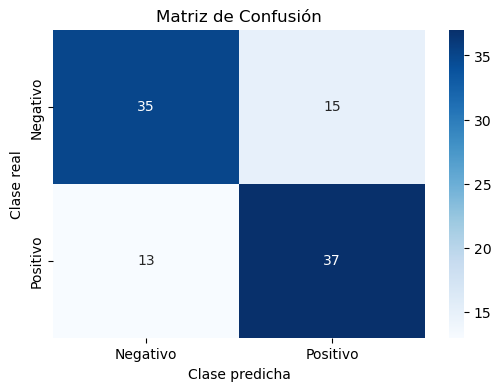


Informe detallado:
               precision    recall  f1-score   support

    Negativo       0.73      0.70      0.71        50
    Positivo       0.71      0.74      0.73        50

    accuracy                           0.72       100
   macro avg       0.72      0.72      0.72       100
weighted avg       0.72      0.72      0.72       100



In [9]:
clasificador_imagenes(X_train, X_test, y_train, y_test)

### Mejora 2: Validación cruzada

In [11]:
def evaluate_model(clasificador, X_test, y_test):
    predictions = clasificador.predict(X_test)

    #Calculamos la precisión
    correct_predictions = np.sum(predictions == y_test)
    total_samples = len(y_test)
    print(f"\nImágenes correctamente clasificadas: {correct_predictions}/{total_samples}")
    print(f"Precisión total: {(correct_predictions / total_samples) * 100:.2f}%")
    
    #Mostramos la matriz de confusión
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negativo", "Positivo"], yticklabels=["Negativo", "Positivo"])
    plt.xlabel("Clase predicha")
    plt.ylabel("Clase real")
    plt.title("Matriz de Confusión")
    plt.show()

    #Mostramos un informe detallado con las medidas de la bondad del clasificador
    report = classification_report(y_test, predictions, target_names=["Negativo", "Positivo"])
    print("\nInforme detallado:\n", report)

In [12]:
def validacion_cruzada(training_data, classes):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    i=1
    
    for train_index, test_index in skf.split(training_data, classes):
        X_train, X_test = training_data[train_index], training_data[test_index]
        y_train, y_test = classes[train_index], classes[test_index]
        
        clasificador = train(X_train, y_train)
        print("Evaluando modelo en pliegue:", i)
        evaluate_model(clasificador, X_test, y_test)
    
        i+=1

Evaluando modelo en pliegue: 1

Imágenes correctamente clasificadas: 59/80
Precisión total: 73.75%


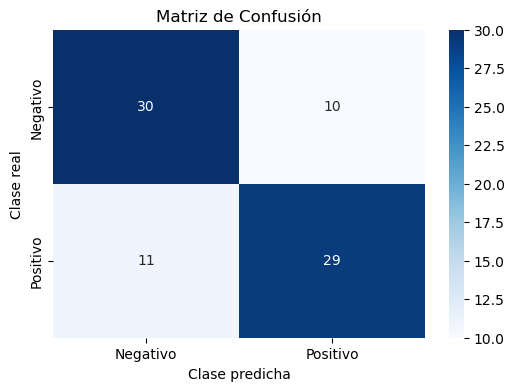


Informe detallado:
               precision    recall  f1-score   support

    Negativo       0.73      0.75      0.74        40
    Positivo       0.74      0.72      0.73        40

    accuracy                           0.74        80
   macro avg       0.74      0.74      0.74        80
weighted avg       0.74      0.74      0.74        80

Evaluando modelo en pliegue: 2

Imágenes correctamente clasificadas: 60/80
Precisión total: 75.00%


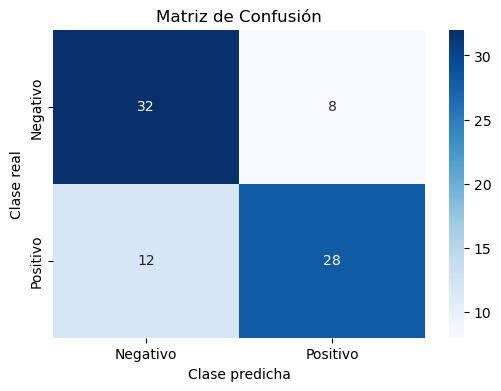


Informe detallado:
               precision    recall  f1-score   support

    Negativo       0.73      0.80      0.76        40
    Positivo       0.78      0.70      0.74        40

    accuracy                           0.75        80
   macro avg       0.75      0.75      0.75        80
weighted avg       0.75      0.75      0.75        80

Evaluando modelo en pliegue: 3

Imágenes correctamente clasificadas: 56/80
Precisión total: 70.00%


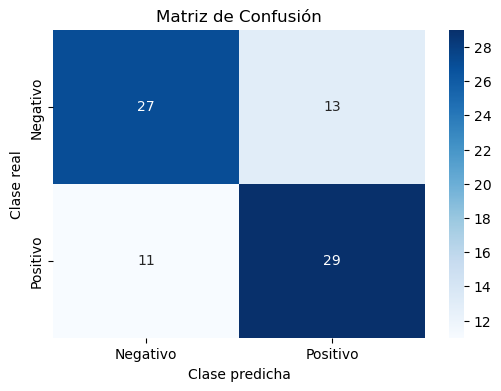


Informe detallado:
               precision    recall  f1-score   support

    Negativo       0.71      0.68      0.69        40
    Positivo       0.69      0.72      0.71        40

    accuracy                           0.70        80
   macro avg       0.70      0.70      0.70        80
weighted avg       0.70      0.70      0.70        80

Evaluando modelo en pliegue: 4

Imágenes correctamente clasificadas: 60/80
Precisión total: 75.00%


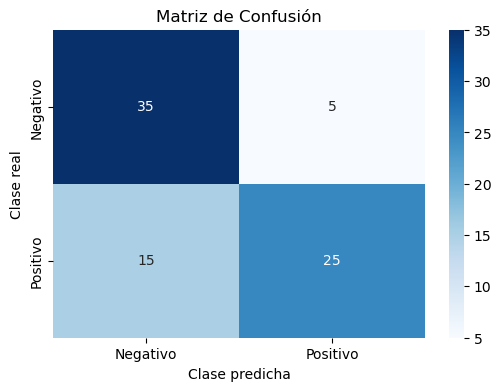


Informe detallado:
               precision    recall  f1-score   support

    Negativo       0.70      0.88      0.78        40
    Positivo       0.83      0.62      0.71        40

    accuracy                           0.75        80
   macro avg       0.77      0.75      0.75        80
weighted avg       0.77      0.75      0.75        80

Evaluando modelo en pliegue: 5

Imágenes correctamente clasificadas: 63/80
Precisión total: 78.75%


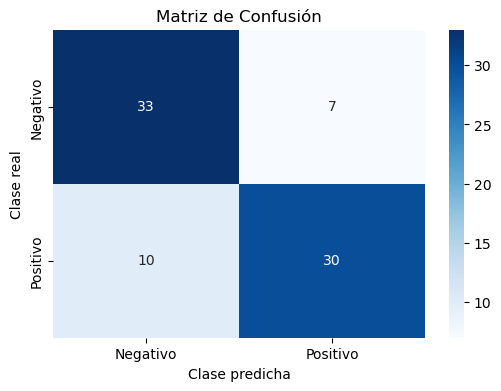


Informe detallado:
               precision    recall  f1-score   support

    Negativo       0.77      0.82      0.80        40
    Positivo       0.81      0.75      0.78        40

    accuracy                           0.79        80
   macro avg       0.79      0.79      0.79        80
weighted avg       0.79      0.79      0.79        80



In [13]:
validacion_cruzada(X_train,y_train)

### Mejora 3: Búsqueda de mejores hiperparámetros

In [15]:
def grid_search(training_data, classes):
    """
    Realiza una búsqueda en la cuadrícula para encontrar los mejores parámetros
    de un clasificador SVM utilizando scikit-learn.
    
    Parameters:
    training_data (np.array): datos de entrenamiento
    classes (np.array): etiquetas de entrenamiento
    
    Returns:
    GridSearchCV: modelo entrenado con los mejores parámetros
    """
    #Definimos los parámetros a explorar
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf','poly'],  # 'linear' y 'rbf' son los equivalentes en sklearn
        'gamma': ['scale', 'auto']   # Para kernels no lineales como 'rbf'
    }
    
    #Definimos el clasificador
    svc = SVC()

    #Validaremos con validación cruzada estratificada
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    #Configuramos GridSearchCV
    grid_search = GridSearchCV(
        svc, 
        param_grid, 
        cv=skf,
        scoring='f1',  #Métrica para optimizar: F1-score
        verbose=3, #Mostrar más info
        #n_jobs=-1 #Usamos todos los nucleos
    )

    print("Ejecutando Grid Search...", flush=True)
    grid_search.fit(training_data, classes) #Buscamos los mejores hiperparámetros

    print("Mejores hiparámetros encontrados:")
    print(grid_search.best_params_)
    print(f"Mejor puntuación (F1): {grid_search.best_score_:.4f}")

    return grid_search

In [16]:
#training_data, classes = load_training_data()
mejor_modelo_HOG=grid_search(X_train, y_train)

Ejecutando Grid Search...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.734 total time=  38.6s
[CV 2/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.737 total time=  35.9s
[CV 3/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.707 total time=  42.1s
[CV 4/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.714 total time=  43.1s
[CV 5/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.779 total time=  38.1s
[CV 1/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.667 total time= 1.3min
[CV 2/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.623 total time= 1.3min
[CV 3/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.576 total time= 1.2min
[CV 4/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.526 total time= 1.2min
[CV 5/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.646 total time= 1.2min
[CV 1/5] END ..C=0.1, gamma=auto, kernel=linear;, score=0.734 total time=  42.4s
[CV 2/5] END ..C=0.1, 


Imágenes correctamente clasificadas: 74/100
Precisión total: 74.00%


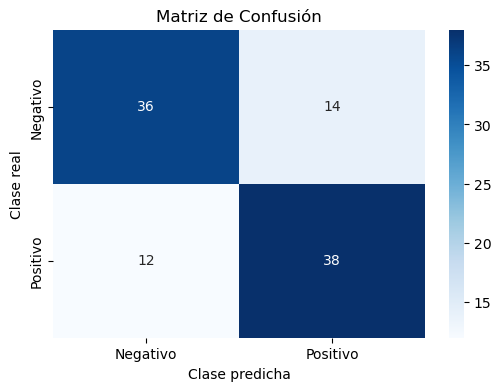


Informe detallado:
               precision    recall  f1-score   support

    Negativo       0.75      0.72      0.73        50
    Positivo       0.73      0.76      0.75        50

    accuracy                           0.74       100
   macro avg       0.74      0.74      0.74       100
weighted avg       0.74      0.74      0.74       100



In [17]:
#Obtenemos los datos de prueba y evaluamos con nuestro mejor modelo
#testing_data, test_classes = load_testing_data()

evaluate_model(mejor_modelo_HOG, X_test, y_test)

### Ejemplos de clasificación

In [91]:
# Hiperparámetros del mejor modelo
best_params = {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

#Tamaño fijo para redimensionar imágenes
fixed_size = (128, 256)

#Cargamos las imágenes de entrenamiento
X_train_HOG, y_train_HOG = load_training_data_HOG()

#Entrenamos el modelo SVM
svm = SVC(C=best_params['C'], gamma=best_params['gamma'], kernel=best_params['kernel'], random_state=42)
svm.fit(X_train_HOG, y_train_HOG)
print("Modelo SVM entrenado con descriptor HOG.")

Leídas 200 imágenes de TRAIN -> positivas
Leídas 200 imágenes de TRAIN -> negativas
Modelo SVM entrenado con descriptor HOG.


In [93]:
#Ruta de imágenes específicas
image_paths = [
    "data_plantas/Test/Test/Healthy/8ddd5ec1c0de38c4.jpg", #Healthy1
    "data_plantas/Test/Test/Healthy/8def4d91382175c3.jpg", #Healthy2
    "data_plantas/Test/Test/Rust/82add70df6ab2854.jpg", #Rust1
    "data_plantas/Test/Test/Rust/84c3f037e53e66a1.jpg", #Rust2
]

#Clasificamos las imágenes específicas
for path in image_paths:
    img = cv2.imread(path)
    img = cv2.resize(img, fixed_size)
    hog_descriptor = cv2.HOGDescriptor()
    descriptor = hog_descriptor.compute(img).flatten()
    prediction = svm.predict(descriptor.reshape(1, -1))[0]
    print(f"Imagen: {path} -> Clase predicha: {'Healthy' if prediction == 0 else 'Rust'}")

Imagen: data_plantas/Test/Test/Healthy/8ddd5ec1c0de38c4.jpg -> Clase predicha: Healthy
Imagen: data_plantas/Test/Test/Healthy/8def4d91382175c3.jpg -> Clase predicha: Rust
Imagen: data_plantas/Test/Test/Rust/82add70df6ab2854.jpg -> Clase predicha: Rust
Imagen: data_plantas/Test/Test/Rust/84c3f037e53e66a1.jpg -> Clase predicha: Healthy


## EJERCICIO 5: Clasificación usando LBP

In [19]:
!pip install scikit-image


In [81]:
from skimage.feature import local_binary_pattern
from skimage.color import rgb2gray

def load_training_data_LBP():
    """
    Lee las imágenes de entrenamiento (positivas y negativas) y calcula sus
    descriptores LBP para el entrenamiento.

    returns:
        np.array: numpy array con los descriptores de las imágenes leídas
        np.array: numpy array con las etiquetas de las imágenes leídas
    """ 
    training_data = []
    classes = []
    fixed_size = (128, 128)  #Redimensionamos las imágenes a tamaño fijo
    random.seed(42)  #Semilla para reproducibilidad

    #Configuración de LBP
    P = 8  # Número de vecinos
    R = 1   # Radio

    # Seleccionamos solo 100 imágenes positivas
    positive_files = [f for f in os.listdir(PATH_POSITIVE_TRAIN) if f.endswith(IMAGE_EXTENSION)]
    selected_positive_files = random.sample(positive_files, min(200, len(positive_files)))

    # Casos positivos
    for filename in selected_positive_files:
        filepath = os.path.join(PATH_POSITIVE_TRAIN, filename)
        img = cv2.imread(filepath)
        if img is None:
            print(f"Error al leer la imagen {filepath}")
            continue
        img = cv2.resize(img, fixed_size)  #Redimensionamos la imagen
        img_gray = rgb2gray(img)  #Convertimos a escala de grises
        
        #Calculamos LBP y su histograma normalizado
        lbp = local_binary_pattern(img_gray, P, R)
        hist, _ = np.histogram(lbp.ravel(), bins=256, range=(0, 256))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)  #Normalizamos el histograma
        
        training_data.append(hist)
        classes.append(1)

    print(f"Leídas {len(selected_positive_files)} imágenes de TRAIN -> positivas")

    # Seleccionamos solo 100 imágenes negativas
    negative_files = [f for f in os.listdir(PATH_NEGATIVE_TRAIN) if f.endswith(IMAGE_EXTENSION)]
    selected_negative_files = random.sample(negative_files, min(200, len(negative_files)))

    # Casos negativos
    for filename in selected_negative_files:
        filepath = os.path.join(PATH_NEGATIVE_TRAIN, filename)
        img = cv2.imread(filepath)
        if img is None:
            print(f"Error al leer la imagen {filepath}")
            continue
        img = cv2.resize(img, fixed_size)  
        img_gray = rgb2gray(img) 

        lbp = local_binary_pattern(img_gray, P, R)
        hist, _ = np.histogram(lbp.ravel(), bins=256, range=(0, 256))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)  

        training_data.append(hist) 
        classes.append(0)

    print(f"Leídas {len(selected_negative_files)} imágenes de TRAIN -> negativas")

    return np.array(training_data), np.array(classes)


def load_testing_data_LBP():
    """
    Lee las imágenes de test (positivas y negativas) y calcula sus
    descriptores LBP.

    returns:
        np.array: numpy array con los descriptores de las imágenes leídas
        np.array: numpy array con las etiquetas de las imágenes leídas
    """ 
    testing_data = []
    classes = []
    fixed_size = (128, 128)  #Redimensionamos las imágenes a tamaño fijo
    random.seed(42)  #Semilla para reproducibilidad

    #Configuración de LBP
    P = 8  #Número de vecinos
    R = 1  #Radio

    #Seleccionamos solo 50 imágenes positivas para test
    positive_files = [f for f in os.listdir(PATH_POSITIVE_TEST) if f.endswith(IMAGE_EXTENSION)]
    selected_positive_files = random.sample(positive_files, min(50, len(positive_files)))

    #Casos positivos
    for filename in selected_positive_files:
        filepath = os.path.join(PATH_POSITIVE_TEST, filename)
        img = cv2.imread(filepath)
        if img is None:
            print(f"Error al leer la imagen {filepath}")
            continue
        img = cv2.resize(img, fixed_size)  #Redimensionamos la imagen
        img_gray = rgb2gray(img)  #Convertimos a escala de grises
        
        #Calculamos LBP y su histograma normalizado
        lbp = local_binary_pattern(img_gray, P, R)
        hist, _ = np.histogram(lbp.ravel(), bins=256, range=(0, 256))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)  #Normalizamos el histograma
        
        testing_data.append(hist)
        classes.append(1)

    print(f"Leídas {len(selected_positive_files)} imágenes de TEST -> positivas")

    #Seleccionamos solo 50 imágenes negativas para test
    negative_files = [f for f in os.listdir(PATH_NEGATIVE_TEST) if f.endswith(IMAGE_EXTENSION)]
    selected_negative_files = random.sample(negative_files, min(50, len(negative_files)))

    #Casos negativos
    for filename in selected_negative_files:
        filepath = os.path.join(PATH_NEGATIVE_TEST, filename)
        img = cv2.imread(filepath)
        if img is None:
            print(f"Error al leer la imagen {filepath}")
            continue
        img = cv2.resize(img, fixed_size)  #Redimensionamos la imagen
        img_gray = rgb2gray(img)  #Convertimos a escala de grises

        lbp = local_binary_pattern(img_gray, P, R)
        hist, _ = np.histogram(lbp.ravel(), bins=256, range=(0, 256))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)  #Normalizamos el histograma

        testing_data.append(hist) 
        classes.append(0)

    print(f"Leídas {len(selected_negative_files)} imágenes de TEST -> negativas")

    return np.array(testing_data), np.array(classes)


In [83]:
#X_train, X_test, y_train, y_test= load_and_split_data_LBP()
X_train, y_train= load_training_data_LBP()

C:\Users\monic\anaconda3\Lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Leídas 200 imágenes de TRAIN -> positivas
Leídas 200 imágenes de TRAIN -> negativas


In [84]:
X_test, y_test= load_testing_data_LBP()

Leídas 50 imágenes de TEST -> positivas
Leídas 50 imágenes de TEST -> negativas


Clasificador entrenado

Imágenes correctamente clasificadas: 70/100
Precisión total: 70.00%


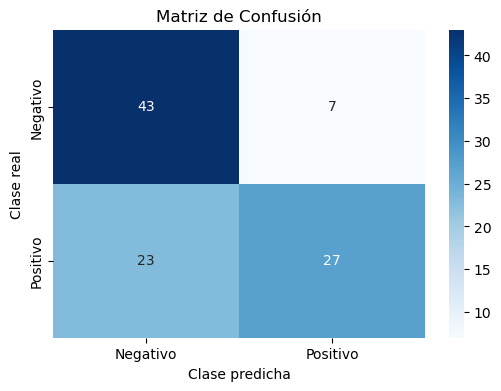


Informe detallado:
               precision    recall  f1-score   support

    Negativo       0.65      0.86      0.74        50
    Positivo       0.79      0.54      0.64        50

    accuracy                           0.70       100
   macro avg       0.72      0.70      0.69       100
weighted avg       0.72      0.70      0.69       100



In [87]:
clasificador_imagenes(X_train, X_test, y_train, y_test)

Evaluando modelo en pliegue: 1

Imágenes correctamente clasificadas: 51/80
Precisión total: 63.75%


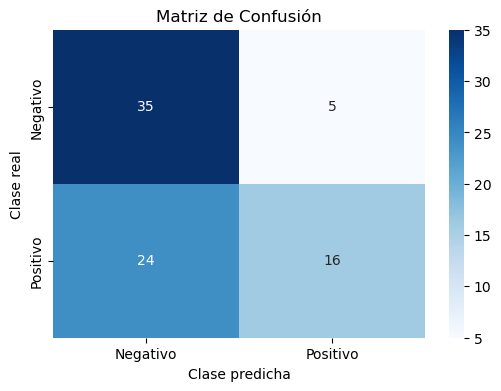


Informe detallado:
               precision    recall  f1-score   support

    Negativo       0.59      0.88      0.71        40
    Positivo       0.76      0.40      0.52        40

    accuracy                           0.64        80
   macro avg       0.68      0.64      0.62        80
weighted avg       0.68      0.64      0.62        80

Evaluando modelo en pliegue: 2

Imágenes correctamente clasificadas: 51/80
Precisión total: 63.75%


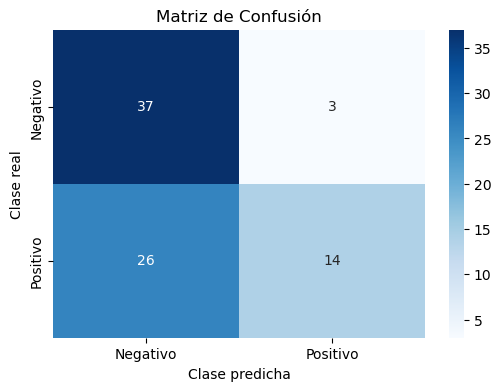


Informe detallado:
               precision    recall  f1-score   support

    Negativo       0.59      0.93      0.72        40
    Positivo       0.82      0.35      0.49        40

    accuracy                           0.64        80
   macro avg       0.71      0.64      0.60        80
weighted avg       0.71      0.64      0.60        80

Evaluando modelo en pliegue: 3

Imágenes correctamente clasificadas: 50/80
Precisión total: 62.50%


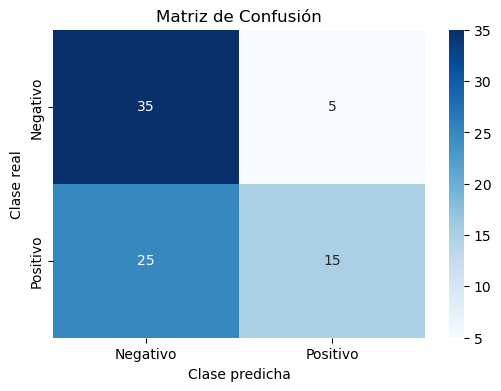


Informe detallado:
               precision    recall  f1-score   support

    Negativo       0.58      0.88      0.70        40
    Positivo       0.75      0.38      0.50        40

    accuracy                           0.62        80
   macro avg       0.67      0.62      0.60        80
weighted avg       0.67      0.62      0.60        80

Evaluando modelo en pliegue: 4

Imágenes correctamente clasificadas: 45/80
Precisión total: 56.25%


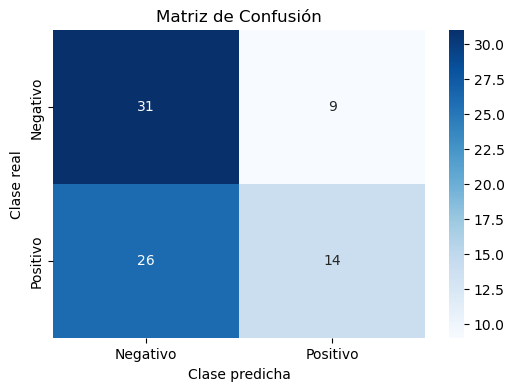


Informe detallado:
               precision    recall  f1-score   support

    Negativo       0.54      0.78      0.64        40
    Positivo       0.61      0.35      0.44        40

    accuracy                           0.56        80
   macro avg       0.58      0.56      0.54        80
weighted avg       0.58      0.56      0.54        80

Evaluando modelo en pliegue: 5

Imágenes correctamente clasificadas: 53/80
Precisión total: 66.25%


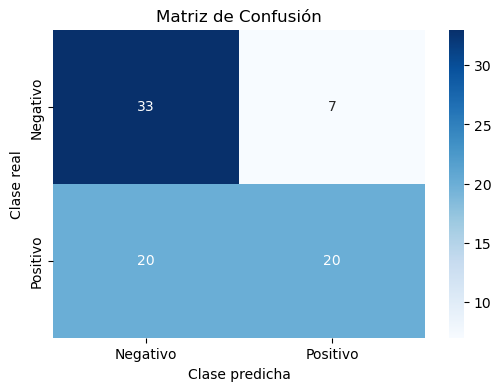


Informe detallado:
               precision    recall  f1-score   support

    Negativo       0.62      0.82      0.71        40
    Positivo       0.74      0.50      0.60        40

    accuracy                           0.66        80
   macro avg       0.68      0.66      0.65        80
weighted avg       0.68      0.66      0.65        80



In [89]:
validacion_cruzada(X_train,y_train)

In [91]:
mejor_modelo_LBP=grid_search(X_train, y_train)

Ejecutando Grid Search...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.525 total time=   0.0s
[CV 2/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.491 total time=   0.0s
[CV 3/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.500 total time=   0.0s
[CV 4/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.444 total time=   0.0s
[CV 5/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.597 total time=   0.0s
[CV 1/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.517 total time=   0.0s
[CV 2/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.415 total time=   0.0s
[CV 3/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.481 total time=   0.0s
[CV 4/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.419 total time=   0.0s
[CV 5/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.540 total time=   0.0s
[CV 1/5] END ..C=0.1, gamma=auto, kernel=linear;, score=0.525 total time=   0.0s
[CV 2/5] END ..C=0.1, 


Imágenes correctamente clasificadas: 75/100
Precisión total: 75.00%


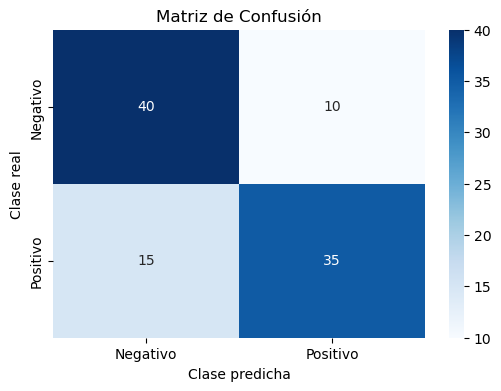


Informe detallado:
               precision    recall  f1-score   support

    Negativo       0.73      0.80      0.76        50
    Positivo       0.78      0.70      0.74        50

    accuracy                           0.75       100
   macro avg       0.75      0.75      0.75       100
weighted avg       0.75      0.75      0.75       100



In [93]:
evaluate_model(mejor_modelo_LBP, X_test, y_test)

### Comparación HOG+SVM vs LBP+SVM

In [77]:
import pandas as pd

def evaluate_svm(best_model, test_data, test_labels, descriptor_name):
    """
    Evalúa un modelo SVM ya entrenado (el mejor obtenido por GridSearchCV) usando los datos de test.

    Parameters:
        best_model: GridSearchCV, modelo entrenado con los mejores parámetros
        test_data: np.array, datos de prueba
        test_labels: np.array, etiquetas de prueba
        descriptor_name: str, nombre del descriptor usado (LBP o HOG)

    Returns:
        dict: diccionario con métricas de evaluación
    """
    # Generamos predicciones
    predictions = best_model.best_estimator_.predict(test_data)

    # Calculamos métricas
    accuracy = accuracy_score(test_labels, predictions)
    correct_predictions = np.sum(predictions == test_labels)
    total_samples = len(test_labels)
    
    
    report = classification_report(test_labels, predictions, target_names=["Negativo", "Positivo"], output_dict=True)
    cm = confusion_matrix(test_labels, predictions)
    
    # Mostramos resultados
    print(f"Resultados de SVM con {descriptor_name}:")
    
    print(f"\nImágenes correctamente clasificadas: {correct_predictions}/{total_samples}")
    print(f"Precisión total: {(correct_predictions / total_samples) * 100:.2f}%")
    
    print("Matriz de Confusión:")
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negativo", "Positivo"], yticklabels=["Negativo", "Positivo"])
    plt.xlabel("Clase predicha")
    plt.ylabel("Clase real")
    plt.title("Matriz de Confusión")
    plt.show()
    
    print("\nInforme de Clasificación:")
    print(classification_report(test_labels, predictions, target_names=["Negativo", "Positivo"]))
    #print(f"Accuracy: {accuracy:.2f}\n")

    # Devolvemos resultados como un diccionario
    return {
        "Descriptor": descriptor_name,
        "Accuracy": accuracy,
        "Precision Negativo": report["Negativo"]["precision"],
        "Recall Negativo": report["Negativo"]["recall"],
        "F1-Score Negativo": report["Negativo"]["f1-score"],
        "Precision Positivo": report["Positivo"]["precision"],
        "Recall Positivo": report["Positivo"]["recall"],
        "F1-Score Positivo": report["Positivo"]["f1-score"]
    }



In [29]:
#Cargamos los datos
print("Leyendo imágenes con descriptor HOG...")
X_train_HOG, y_train_HOG = load_training_data_HOG() 
X_test_HOG, y_test_HOG = load_testing_data_HOG()


Leyendo imágenes con descriptor HOG...
Leídas 200 imágenes de TRAIN -> positivas
Leídas 200 imágenes de TRAIN -> negativas
Leídas 50 imágenes de TEST -> positivas
Leídas 50 imágenes de TEST -> negativas
Leyendo imágenes con descriptor LBP...


C:\Users\monic\anaconda3\Lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Leídas 200 imágenes de TRAIN -> positivas
Leídas 200 imágenes de TRAIN -> negativas
Leídas 50 imágenes de TEST -> positivas
Leídas 50 imágenes de TEST -> negativas


In [95]:
print("Leyendo imágenes con descriptor LBP...")
X_train_LBP, y_train_LBP = load_training_data_LBP()
X_test_LBP, y_test_LBP = load_testing_data_LBP()

Leyendo imágenes con descriptor LBP...


C:\Users\monic\anaconda3\Lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Leídas 200 imágenes de TRAIN -> positivas
Leídas 200 imágenes de TRAIN -> negativas
Leídas 50 imágenes de TEST -> positivas
Leídas 50 imágenes de TEST -> negativas



Imágenes correctamente clasificadas: 74/100
Precisión total: 74.00%
Resultados de SVM con HOG:
Matriz de Confusión:


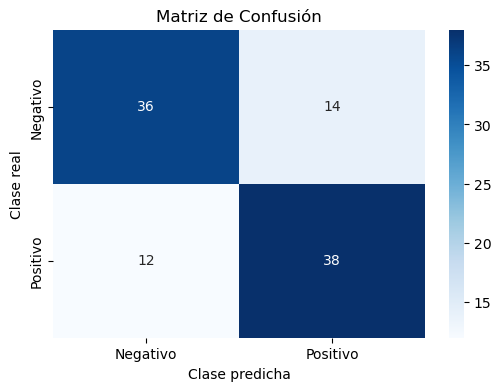


Informe de Clasificación:
              precision    recall  f1-score   support

    Negativo       0.75      0.72      0.73        50
    Positivo       0.73      0.76      0.75        50

    accuracy                           0.74       100
   macro avg       0.74      0.74      0.74       100
weighted avg       0.74      0.74      0.74       100

Accuracy: 0.74


Imágenes correctamente clasificadas: 75/100
Precisión total: 75.00%
Resultados de SVM con LBP:
Matriz de Confusión:


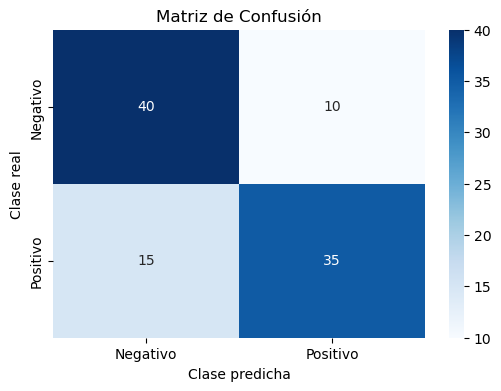


Informe de Clasificación:
              precision    recall  f1-score   support

    Negativo       0.73      0.80      0.76        50
    Positivo       0.78      0.70      0.74        50

    accuracy                           0.75       100
   macro avg       0.75      0.75      0.75       100
weighted avg       0.75      0.75      0.75       100

Accuracy: 0.75

Comparativa de resultados:
  Descriptor  Accuracy  Precision Negativo  Recall Negativo  \
0        HOG      0.74            0.750000             0.72   
1        LBP      0.75            0.727273             0.80   

   F1-Score Negativo  Precision Positivo  Recall Positivo  F1-Score Positivo  
0           0.734694            0.730769             0.76           0.745098  
1           0.761905            0.777778             0.70           0.736842  


In [96]:
#Evaluamos los mejores modelos para SVM+HOG y SVM+LBP
results_HOG = evaluate_svm(mejor_modelo_HOG, X_test_HOG, y_test_HOG, "HOG")
results_LBP = evaluate_svm(mejor_modelo_LBP, X_test_LBP, y_test_LBP, "LBP")

results_df = pd.DataFrame([results_HOG, results_LBP])
print("Comparativa de resultados:")
print(results_df)

## EJERCICIO 6: LBP Uniforme

In [100]:
def load_training_data_LBP_uniform():
    """
    Lee las imágenes de entrenamiento (positivas y negativas) y calcula sus
    descriptores LBP uniforme para el entrenamiento.

    returns:
        np.array: numpy array con los descriptores de las imágenes leídas
        np.array: numpy array con las etiquetas de las imágenes leídas
    """ 
    training_data = []
    classes = []
    fixed_size = (128, 128) #Redimensionamos las imágenes a tamaño fijo
    random.seed(42) #Semilla para reproducibilidad

    #Configuración de LBP-uniforme
    P = 8 #Número de vecinos
    R = 1 #Radio

    #Seleccionamos solo 200 imágenes positivas
    positive_files = [f for f in os.listdir(PATH_POSITIVE_TRAIN) if f.endswith(IMAGE_EXTENSION)]
    selected_positive_files = random.sample(positive_files, min(200, len(positive_files)))

    #Casos positivos
    for filename in selected_positive_files:
        filepath = os.path.join(PATH_POSITIVE_TRAIN, filename)
        img = cv2.imread(filepath)
        if img is None:
            print(f"Error al leer la imagen {filepath}")
            continue
        img = cv2.resize(img, fixed_size) #Redimensionamos la imagen
        img_gray = rgb2gray(img) #Convertimos a escala de grises
        
        #Calculamos LBP uniforme y su histograma normalizado
        lbp = local_binary_pattern(img_gray, P, R, method='uniform')
        n_bins = P + 2 #Número de bins para LBP uniforme
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_bins + 1), range=(0, n_bins))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6) #Normalizamos el histograma
        
        training_data.append(hist)
        classes.append(1)

    print(f"Leídas {len(selected_positive_files)} imágenes de TRAIN -> positivas")

    #Seleccionamos solo 200 imágenes negativas
    negative_files = [f for f in os.listdir(PATH_NEGATIVE_TRAIN) if f.endswith(IMAGE_EXTENSION)]
    selected_negative_files = random.sample(negative_files, min(200, len(negative_files)))

    #Casos negativos
    for filename in selected_negative_files:
        filepath = os.path.join(PATH_NEGATIVE_TRAIN, filename)
        img = cv2.imread(filepath)
        if img is None:
            print(f"Error al leer la imagen {filepath}")
            continue
        img = cv2.resize(img, fixed_size) #Redimensionamos la imagen
        img_gray = rgb2gray(img) #Convertimos a escala de grises

        #Calculamos LBP uniforme y su histograma normalizado
        lbp = local_binary_pattern(img_gray, P, R, method='uniform')
        n_bins = P + 2 #Número de bins para LBP uniforme
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_bins + 1), range=(0, n_bins))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6) #Normalizamos el histograma

        training_data.append(hist)
        classes.append(0)

    print(f"Leídas {len(selected_negative_files)} imágenes de TRAIN -> negativas")

    return np.array(training_data), np.array(classes)



def load_testing_data_LBP_uniform():
    """
    Lee las imágenes de test (positivas y negativas) y calcula sus
    descriptores LBP uniforme.

    returns:
        np.array: numpy array con los descriptores de las imágenes leídas
        np.array: numpy array con las etiquetas de las imágenes leídas
    """ 
    testing_data = []
    classes = []
    fixed_size = (128, 128) #Redimensionamos las imágenes a tamaño fijo
    random.seed(42) #Semilla para reproducibilidad

    #Configuración de LBP uniforme
    P = 8 #Número de vecinos
    R = 1 #Radio

    #Seleccionamos solo 50 imágenes positivas para test
    positive_files = [f for f in os.listdir(PATH_POSITIVE_TEST) if f.endswith(IMAGE_EXTENSION)]
    selected_positive_files = random.sample(positive_files, min(50, len(positive_files)))

    #Casos positivos
    for filename in selected_positive_files:
        filepath = os.path.join(PATH_POSITIVE_TEST, filename)
        img = cv2.imread(filepath)
        if img is None:
            print(f"Error al leer la imagen {filepath}")
            continue
        img = cv2.resize(img, fixed_size) #Redimensionamos la imagen
        img_gray = rgb2gray(img) #Convertimos a escala de grises
        
        #Calculamos LBP uniforme y su histograma normalizado
        lbp = local_binary_pattern(img_gray, P, R, method='uniform')
        n_bins = P + 2 #Número de bins para LBP uniforme
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_bins + 1), range=(0, n_bins))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6) #Normalizamos el histograma
        
        testing_data.append(hist)
        classes.append(1)

    print(f"Leídas {len(selected_positive_files)} imágenes de TEST -> positivas")

    #Seleccionamos solo 50 imágenes negativas para test
    negative_files = [f for f in os.listdir(PATH_NEGATIVE_TEST) if f.endswith(IMAGE_EXTENSION)]
    selected_negative_files = random.sample(negative_files, min(50, len(negative_files)))

    #Casos negativos
    for filename in selected_negative_files:
        filepath = os.path.join(PATH_NEGATIVE_TEST, filename)
        img = cv2.imread(filepath)
        if img is None:
            print(f"Error al leer la imagen {filepath}")
            continue
        img = cv2.resize(img, fixed_size) #Redimensionamos la imagen
        img_gray = rgb2gray(img) #Convertimos a escala de grises

        lbp = local_binary_pattern(img_gray, P, R, method='uniform')
        n_bins = P + 2 #Número de bins para LBP uniforme
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_bins + 1), range=(0, n_bins))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6) #Normalizamos el histograma

        testing_data.append(hist) 
        classes.append(0)

    print(f"Leídas {len(selected_negative_files)} imágenes de TEST -> negativas")

    return np.array(testing_data), np.array(classes)


In [102]:
#Cargamos datos de LBP-uniforme
X_train_LBP_uniform, y_train_LBP_uniform = load_training_data_LBP_uniform()
X_test_LBP_uniform, y_test_LBP_uniform = load_testing_data_LBP_uniform()

C:\Users\monic\anaconda3\Lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Leídas 200 imágenes de TRAIN -> positivas
Leídas 200 imágenes de TRAIN -> negativas
Leídas 50 imágenes de TEST -> positivas
Leídas 50 imágenes de TEST -> negativas


Ejecutando Grid Search...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.415 total time=   0.0s
[CV 2/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.481 total time=   0.0s
[CV 3/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.456 total time=   0.0s
[CV 4/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.386 total time=   0.0s
[CV 5/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.554 total time=   0.0s
[CV 1/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.464 total time=   0.0s
[CV 2/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.392 total time=   0.0s
[CV 3/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.448 total time=   0.0s
[CV 4/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.467 total time=   0.0s
[CV 5/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.500 total time=   0.0s
[CV 1/5] END ..C=0.1, gamma=auto, kernel=linear;, score=0.415 total time=   0.0s
[CV 2/5] END ..C=0.1, 

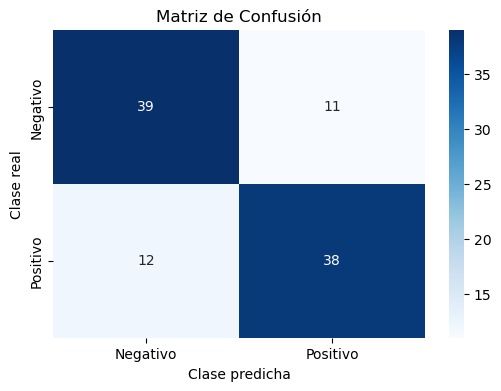


Informe de Clasificación:
              precision    recall  f1-score   support

    Negativo       0.76      0.78      0.77        50
    Positivo       0.78      0.76      0.77        50

    accuracy                           0.77       100
   macro avg       0.77      0.77      0.77       100
weighted avg       0.77      0.77      0.77       100

Accuracy: 0.77



In [106]:
# Entrenar y evaluar con Grid Search
mejor_modelo_LBP_uniform = grid_search(X_train_LBP_uniform, y_train_LBP_uniform)
results_LBP_uniform = evaluate_svm(mejor_modelo_LBP_uniform, X_test_LBP_uniform, y_test_LBP_uniform, "LBP-Uniform")

In [108]:
# Comparar con HOG y LBP básico
results_df = pd.DataFrame([results_HOG, results_LBP, results_LBP_uniform])
print("Comparativa de resultados:")
print(results_df)

Comparativa de resultados:
    Descriptor  Accuracy  Precision Negativo  Recall Negativo  \
0          HOG      0.74            0.750000             0.72   
1          LBP      0.75            0.727273             0.80   
2  LBP-Uniform      0.77            0.764706             0.78   

   F1-Score Negativo  Precision Positivo  Recall Positivo  F1-Score Positivo  
0           0.734694            0.730769             0.76           0.745098  
1           0.761905            0.777778             0.70           0.736842  
2           0.772277            0.775510             0.76           0.767677  


## EJERCICIO 8. Incluir más clases

Por suerte, el dataset que hemos escogido contiene realmente 3 clases: Healthy, Rust y Powdery. La tercera clase consiste en otra enfermedad de las hojas en la que se forma una capa blanca sobre su superficie. 

Voy a redefinir las funciones para leer imágenes de forma que podamos leer más clases en lugar de solo dos.

#### HOG

In [57]:
PATH_HEALTHY_TRAIN = "data_plantas/Train/Train/Healthy/"
PATH_RUST_TRAIN = "data_plantas/Train/Train/Rust/"
PATH_POWDERY_TRAIN = "data_plantas/Train/Train/Powdery/"
PATH_HEALTHY_TEST = "data_plantas/Test/Test/Healthy/"
PATH_RUST_TEST = "data_plantas/Test/Test/Rust/"
PATH_POWDERY_TEST = "data_plantas/Test/Test/Powdery/"
IMAGE_EXTENSION = ".jpg"
  
def load_training_data_HOG_multiple():
    """
    Lee las imágenes de entrenamiento para múltiples clases (Healthy, Powdery, Rust) 
    y calcula sus descriptores HOG.

    returns:
        np.array: numpy array con los descriptores de las imágenes leídas
        np.array: numpy array con las etiquetas de las imágenes leídas
    """ 
    training_data = []
    classes = []
    fixed_size = (128, 256) #Redimensionamos las imágenes a tamaño fijo
    random.seed(42) #Semilla para reproducibilidad

    #Diccionario con las rutas y etiquetas de cada clase
    class_paths = {
        0: PATH_HEALTHY_TRAIN,
        1: PATH_POWDERY_TRAIN,
        2: PATH_RUST_TRAIN
    }

    #Procesar cada clase
    for label, path in class_paths.items():
        files = [f for f in os.listdir(path) if f.endswith(IMAGE_EXTENSION)]
        selected_files = random.sample(files, min(80, len(files)))

        for filename in selected_files:
            filepath = os.path.join(path, filename)
            img = cv2.imread(filepath)
            if img is None:
                print(f"Error al leer la imagen {filepath}")
                continue
            img = cv2.resize(img, fixed_size) #Redimensionamos la imagen
            hog = cv2.HOGDescriptor()
            descriptor = hog.compute(img)
            training_data.append(descriptor.flatten()) #Convirtimos a 1D para consistencia
            classes.append(label)

        print(f"Leídas {len(selected_files)} imágenes de TRAIN -> Clase {label}")

    return np.array(training_data), np.array(classes)

def load_testing_data_HOG_multiple():
    """
    Lee las imágenes de prueba para múltiples clases (Healthy, Powdery, Rust) 
    y calcula sus descriptores HOG.

    returns:
        np.array: numpy array con los descriptores de las imágenes leídas
        np.array: numpy array con las etiquetas de las imágenes leídas
    """ 
    testing_data = []
    classes = []
    fixed_size = (128, 256) #Redimensionamos las imágenes a tamaño fijo
    random.seed(42) #Semilla para reproducibilidad

    #Diccionario con las rutas y etiquetas de cada clase
    class_paths = {
        0: PATH_HEALTHY_TEST,
        1: PATH_POWDERY_TEST,
        2: PATH_RUST_TEST
    }

    #Procesar cada clase
    for label, path in class_paths.items():
        files = [f for f in os.listdir(path) if f.endswith(IMAGE_EXTENSION)]
        selected_files = random.sample(files, min(20, len(files))) #Seleccionamos solo 50 imágenes para prueba

        for filename in selected_files:
            filepath = os.path.join(path, filename)
            img = cv2.imread(filepath)
            if img is None:
                print(f"Error al leer la imagen {filepath}")
                continue
            img = cv2.resize(img, fixed_size) #Redimensionamos la imagen
            hog = cv2.HOGDescriptor()
            descriptor = hog.compute(img)
            testing_data.append(descriptor.flatten()) #Convirtimos a 1D para consistencia
            classes.append(label)

        print(f"Leídas {len(selected_files)} imágenes de TEST -> Clase {label}")

    return np.array(testing_data), np.array(classes)
 

In [59]:
X_train_HOG, y_train_HOG= load_training_data_HOG_multiple()
X_test_HOG, y_test_HOG= load_testing_data_HOG_multiple()

Leídas 80 imágenes de TRAIN -> Clase 0
Leídas 80 imágenes de TRAIN -> Clase 1
Leídas 80 imágenes de TRAIN -> Clase 2
Leídas 20 imágenes de TEST -> Clase 0
Leídas 20 imágenes de TEST -> Clase 1
Leídas 20 imágenes de TEST -> Clase 2


In [29]:
def grid_search_multiple(training_data, classes):
    """
    Realiza una búsqueda en la cuadrícula para encontrar los mejores parámetros
    de un clasificador SVM utilizando scikit-learn, soportando múltiples clases.
    
    Parameters:
    training_data (np.array): datos de entrenamiento
    classes (np.array): etiquetas de entrenamiento
    
    Returns:
    GridSearchCV: modelo entrenado con los mejores parámetros
    """
    #Definimos los parámetros a explorar
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto']   # Para kernels no lineales como 'rbf'
    }
    
    #Definimos el clasificador
    svc = SVC(decision_function_shape='ovr')  #Configuración para múltiples clases

    #Validaremos con validación cruzada estratificada
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    #Configuramos GridSearchCV
    grid_search = GridSearchCV(
        svc, 
        param_grid, 
        cv=skf,
        scoring='f1_macro',  #Métrica para optimizar: F1-score macro para múltiples clases
        verbose=3, #Mostrar más info
    )

    print("Ejecutando Grid Search...", flush=True)
    grid_search.fit(training_data, classes) #Buscamos los mejores hiperparámetros

    print("Mejores hiperparámetros encontrados:")
    print(grid_search.best_params_)
    print(f"Mejor puntuación (F1 Macro): {grid_search.best_score_:.4f}")

    return grid_search

In [61]:
mejor_modelo_HOG_multiple = grid_search_multiple(X_train_HOG, y_train_HOG)

Ejecutando Grid Search...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.720 total time=  19.4s
[CV 2/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.625 total time=  19.2s
[CV 3/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.572 total time=  22.7s
[CV 4/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.573 total time=  22.1s
[CV 5/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.480 total time=  18.9s
[CV 1/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.661 total time=  36.5s
[CV 2/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.530 total time=  41.7s
[CV 3/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.624 total time=  45.8s
[CV 4/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.640 total time=  33.1s
[CV 5/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.470 total time=  35.1s
[CV 1/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.720 total time=  23.7s
[CV 2/5] END ...C=0.1

In [11]:
def evaluate_model_multiple(clasificador, X_test, y_test, class_names):
    """
    Evalúa un modelo y muestra métricas de rendimiento para múltiples clases.

    Parameters:
        clasificador: Modelo entrenado (SVM u otro).
        X_test: np.array, datos de prueba.
        y_test: np.array, etiquetas de prueba.
        class_names: list, nombres de las clases.
    """
    # Generamos predicciones
    predictions = clasificador.predict(X_test)

    # Verificamos las clases presentes en las etiquetas y predicciones
    print("Clases en y_test:", np.unique(y_test))
    print("Clases en predicciones:", np.unique(predictions))

    # Calculamos la precisión
    correct_predictions = np.sum(predictions == y_test)
    total_samples = len(y_test)
    print(f"\nImágenes correctamente clasificadas: {correct_predictions}/{total_samples}")
    print(f"Precisión total: {(correct_predictions / total_samples) * 100:.2f}%")
    
    # Mostramos la matriz de confusión
    cm = confusion_matrix(y_test, predictions, labels=[0, 1, 2])
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.xlabel("Clase predicha")
    plt.ylabel("Clase real")
    plt.title("Matriz de Confusión")
    plt.show()

    # Mostramos un informe detallado con las medidas de la bondad del clasificador
    report = classification_report(y_test, predictions, target_names=class_names, labels=[0, 1, 2])
    print("\nInforme detallado:\n", report)


Clases en y_test: [0 1 2]
Clases en predicciones: [0 1 2]

Imágenes correctamente clasificadas: 30/60
Precisión total: 50.00%


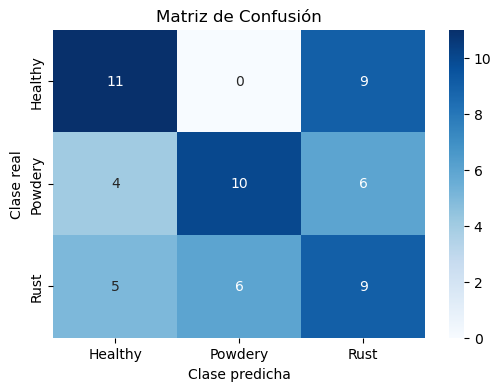


Informe detallado:
               precision    recall  f1-score   support

     Healthy       0.55      0.55      0.55        20
     Powdery       0.62      0.50      0.56        20
        Rust       0.38      0.45      0.41        20

    accuracy                           0.50        60
   macro avg       0.52      0.50      0.50        60
weighted avg       0.52      0.50      0.50        60



In [72]:
class_names = ["Healthy", "Powdery", "Rust"]
evaluate_model_multiple(mejor_modelo_HOG_multiple, X_test_HOG, y_test_HOG, class_names)

#### LBP básico

In [23]:
from skimage.feature import local_binary_pattern
from skimage.color import rgb2gray

def load_training_data_LBP_multiple():
    """
    Lee las imágenes de entrenamiento para múltiples clases (Healthy, Powdery, Rust) 
    y calcula sus descriptores LBP básico.

    returns:
        np.array: numpy array con los descriptores de las imágenes leídas
        np.array: numpy array con las etiquetas de las imágenes leídas
    """ 
    training_data = []
    classes = []
    fixed_size = (128, 128) #Redimensionamos las imágenes a tamaño fijo
    random.seed(42) #Semilla para reproducibilidad

    #Configuración de LBP
    P = 8 #Número de vecinos
    R = 1 #Radio

    #Diccionario con las rutas y etiquetas de cada clase
    class_paths = {
        0: PATH_HEALTHY_TRAIN,
        1: PATH_POWDERY_TRAIN,
        2: PATH_RUST_TRAIN
    }

    #Procesar cada clase
    for label, path in class_paths.items():
        files = [f for f in os.listdir(path) if f.endswith(IMAGE_EXTENSION)]
        selected_files = random.sample(files, min(200, len(files)))

        for filename in selected_files:
            filepath = os.path.join(path, filename)
            img = cv2.imread(filepath)
            if img is None:
                print(f"Error al leer la imagen {filepath}")
                continue
            img = cv2.resize(img, fixed_size) #Redimensionamos la imagen
            img_gray = rgb2gray(img) #Convertimos a escala de grises
            
            #Calculamos LBP básico y su histograma
            lbp = local_binary_pattern(img_gray, P, R)
            hist, _ = np.histogram(lbp.ravel(), bins=256, range=(0, 256))
            hist = hist.astype("float")
            hist /= (hist.sum() + 1e-6) #Normalizamos el histograma

            training_data.append(hist) #Añadimos el histograma normalizado
            classes.append(label)

        print(f"Leídas {len(selected_files)} imágenes de TRAIN -> Clase {label}")

    return np.array(training_data), np.array(classes)


def load_testing_data_LBP_multiple():
    """
    Lee las imágenes de prueba para múltiples clases (Healthy, Powdery, Rust) 
    y calcula sus descriptores LBP básico.

    returns:
        np.array: numpy array con los descriptores de las imágenes leídas
        np.array: numpy array con las etiquetas de las imágenes leídas
    """ 
    testing_data = []
    classes = []
    fixed_size = (128, 128) #Redimensionamos las imágenes a tamaño fijo
    random.seed(42) #Semilla para reproducibilidad

    #Configuración de LBP
    P = 8 #Número de vecinos
    R = 1 #Radio

    #Diccionario con las rutas y etiquetas de cada clase
    class_paths = {
        0: PATH_HEALTHY_TEST,
        1: PATH_POWDERY_TEST,
        2: PATH_RUST_TEST
    }

    #Procesar cada clase
    for label, path in class_paths.items():
        files = [f for f in os.listdir(path) if f.endswith(IMAGE_EXTENSION)]
        selected_files = random.sample(files, min(50, len(files))) #Seleccionamos solo 50 imágenes para prueba

        for filename in selected_files:
            filepath = os.path.join(path, filename)
            img = cv2.imread(filepath)
            if img is None:
                print(f"Error al leer la imagen {filepath}")
                continue
            img = cv2.resize(img, fixed_size) #Redimensionamos la imagen
            img_gray = rgb2gray(img) #Convertimos a escala de grises

            #Calculamos LBP básico y su histograma
            lbp = local_binary_pattern(img_gray, P, R)
            hist, _ = np.histogram(lbp.ravel(), bins=256, range=(0, 256))
            hist = hist.astype("float")
            hist /= (hist.sum() + 1e-6) #Normalizamos el histograma

            testing_data.append(hist) #Añadimos el histograma normalizado
            classes.append(label)

        print(f"Leídas {len(selected_files)} imágenes de TEST -> Clase {label}")

    return np.array(testing_data), np.array(classes)


In [25]:
X_train_LBP, y_train_LBP= load_training_data_LBP_multiple()
X_test_LBP, y_test_LBP= load_testing_data_LBP_multiple()

Leídas 200 imágenes de TRAIN -> Clase 0
Leídas 200 imágenes de TRAIN -> Clase 1
Leídas 200 imágenes de TRAIN -> Clase 2
Leídas 50 imágenes de TEST -> Clase 0
Leídas 50 imágenes de TEST -> Clase 1
Leídas 50 imágenes de TEST -> Clase 2


In [31]:
mejor_modelo_LBP_multiple = grid_search_multiple(X_train_LBP, y_train_LBP)

Ejecutando Grid Search...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.441 total time=   0.0s
[CV 2/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.416 total time=   0.0s
[CV 3/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.432 total time=   0.0s
[CV 4/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.532 total time=   0.0s
[CV 5/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.442 total time=   0.0s
[CV 1/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.461 total time=   0.0s
[CV 2/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.458 total time=   0.0s
[CV 3/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.407 total time=   0.0s
[CV 4/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.459 total time=   0.0s
[CV 5/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.445 total time=   0.0s
[CV 1/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.436 total time=   0.0s
[CV 2/5] END ...C=0.1

Clases en y_test: [0 1 2]
Clases en predicciones: [0 1 2]

Imágenes correctamente clasificadas: 110/150
Precisión total: 73.33%


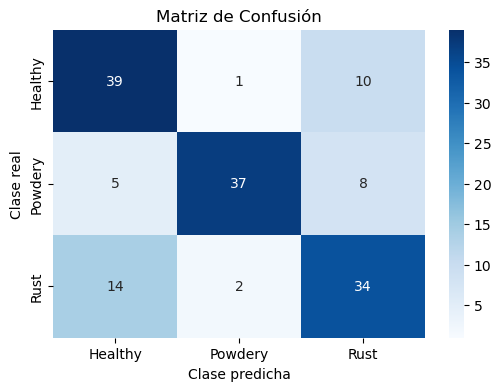


Informe detallado:
               precision    recall  f1-score   support

     Healthy       0.67      0.78      0.72        50
     Powdery       0.93      0.74      0.82        50
        Rust       0.65      0.68      0.67        50

    accuracy                           0.73       150
   macro avg       0.75      0.73      0.74       150
weighted avg       0.75      0.73      0.74       150



In [33]:
class_names = ["Healthy", "Powdery", "Rust"]
evaluate_model_multiple(mejor_modelo_LBP_multiple, X_test_LBP, y_test_LBP, class_names)

#### LBP Uniforme

In [39]:
def load_training_data_LBP_uniform_multiple():
    """
    Lee las imágenes de entrenamiento para múltiples clases (Healthy, Powdery, Rust) 
    y calcula sus descriptores LBP básico.

    returns:
        np.array: numpy array con los descriptores de las imágenes leídas
        np.array: numpy array con las etiquetas de las imágenes leídas
    """ 
    training_data = []
    classes = []
    fixed_size = (128, 128) #Redimensionamos las imágenes a tamaño fijo
    random.seed(42) #Semilla para reproducibilidad

    #Configuración de LBP
    P = 8 #Número de vecinos
    R = 1 #Radio

    #Diccionario con las rutas y etiquetas de cada clase
    class_paths = {
        0: PATH_HEALTHY_TRAIN,
        1: PATH_POWDERY_TRAIN,
        2: PATH_RUST_TRAIN
    }

    #Procesar cada clase
    for label, path in class_paths.items():
        files = [f for f in os.listdir(path) if f.endswith(IMAGE_EXTENSION)]
        selected_files = random.sample(files, min(200, len(files)))

        for filename in selected_files:
            filepath = os.path.join(path, filename)
            img = cv2.imread(filepath)
            if img is None:
                print(f"Error al leer la imagen {filepath}")
                continue
            img = cv2.resize(img, fixed_size) #Redimensionamos la imagen
            img_gray = rgb2gray(img) #Convertimos a escala de grises

            #Calculamos LBP uniforme y su histograma normalizado
            lbp = local_binary_pattern(img_gray, P, R, method='uniform')
            n_bins = P + 2 #Número de bins para LBP uniforme
            hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_bins + 1), range=(0, n_bins))
            hist = hist.astype("float")
            hist /= (hist.sum() + 1e-6) #Normalizamos el histograma

            training_data.append(hist) #Añadimos el histograma normalizado
            classes.append(label)

        print(f"Leídas {len(selected_files)} imágenes de TRAIN -> Clase {label}")

    return np.array(training_data), np.array(classes)


def load_testing_data_LBP_uniform_multiple():
    """
    Lee las imágenes de prueba para múltiples clases (Healthy, Powdery, Rust) 
    y calcula sus descriptores LBP básico.

    returns:
        np.array: numpy array con los descriptores de las imágenes leídas
        np.array: numpy array con las etiquetas de las imágenes leídas
    """ 
    testing_data = []
    classes = []
    fixed_size = (128, 128) #Redimensionamos las imágenes a tamaño fijo
    random.seed(42) #Semilla para reproducibilidad

    #Configuración de LBP
    P = 8 #Número de vecinos
    R = 1 #Radio

    #Diccionario con las rutas y etiquetas de cada clase
    class_paths = {
        0: PATH_HEALTHY_TEST,
        1: PATH_POWDERY_TEST,
        2: PATH_RUST_TEST
    }

    #Procesar cada clase
    for label, path in class_paths.items():
        files = [f for f in os.listdir(path) if f.endswith(IMAGE_EXTENSION)]
        selected_files = random.sample(files, min(50, len(files))) #Seleccionamos solo 50 imágenes para prueba

        for filename in selected_files:
            filepath = os.path.join(path, filename)
            img = cv2.imread(filepath)
            if img is None:
                print(f"Error al leer la imagen {filepath}")
                continue
            img = cv2.resize(img, fixed_size) #Redimensionamos la imagen
            img_gray = rgb2gray(img) #Convertimos a escala de grises

            #Calculamos LBP uniforme y su histograma normalizado
            lbp = local_binary_pattern(img_gray, P, R, method='uniform')
            n_bins = P + 2 #Número de bins para LBP uniforme
            hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_bins + 1), range=(0, n_bins))
            hist = hist.astype("float")
            hist /= (hist.sum() + 1e-6) #Normalizamos el histograma

            testing_data.append(hist) #Añadimos el histograma normalizado
            classes.append(label)

        print(f"Leídas {len(selected_files)} imágenes de TEST -> Clase {label}")

    return np.array(testing_data), np.array(classes)

In [41]:
X_train_LBP_uniform, y_train_LBP_uniform= load_training_data_LBP_uniform_multiple()
X_test_LBP_uniform, y_test_LBP_uniform= load_testing_data_LBP_uniform_multiple()

C:\Users\monic\anaconda3\Lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Leídas 200 imágenes de TRAIN -> Clase 0
Leídas 200 imágenes de TRAIN -> Clase 1
Leídas 200 imágenes de TRAIN -> Clase 2
Leídas 50 imágenes de TEST -> Clase 0
Leídas 50 imágenes de TEST -> Clase 1
Leídas 50 imágenes de TEST -> Clase 2


In [42]:
mejor_modelo_LBP_uniform_multiple = grid_search_multiple(X_train_LBP_uniform, y_train_LBP_uniform)

Ejecutando Grid Search...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.362 total time=   0.0s
[CV 2/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.405 total time=   0.0s
[CV 3/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.461 total time=   0.0s
[CV 4/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.499 total time=   0.0s
[CV 5/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.443 total time=   0.0s
[CV 1/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.394 total time=   0.0s
[CV 2/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.447 total time=   0.0s
[CV 3/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.400 total time=   0.0s
[CV 4/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.440 total time=   0.0s
[CV 5/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.443 total time=   0.0s
[CV 1/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.660 total time=   0.0s
[CV 2/5] END ...C=0.1

Clases en y_test: [0 1 2]
Clases en predicciones: [0 1 2]

Imágenes correctamente clasificadas: 99/150
Precisión total: 66.00%


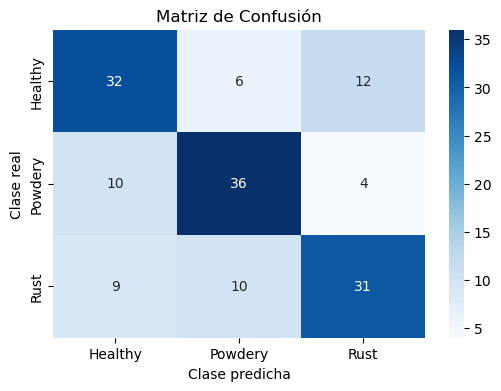


Informe detallado:
               precision    recall  f1-score   support

     Healthy       0.63      0.64      0.63        50
     Powdery       0.69      0.72      0.71        50
        Rust       0.66      0.62      0.64        50

    accuracy                           0.66       150
   macro avg       0.66      0.66      0.66       150
weighted avg       0.66      0.66      0.66       150



In [43]:
class_names = ["Healthy", "Powdery", "Rust"]
evaluate_model_multiple(mejor_modelo_LBP_uniform_multiple, X_test_LBP_uniform, y_test_LBP_uniform, class_names)

#### Comparación HOG+SVM, LBP+SVM, LBPu+SVM para 3 clases

In [74]:
def evaluate_svm_multiple(best_model, test_data, test_labels, descriptor_name, class_names):
    """
    Evalúa un modelo SVM ya entrenado (el mejor obtenido por GridSearchCV) usando los datos de test.

    Parameters:
        best_model: GridSearchCV, modelo entrenado con los mejores parámetros
        test_data: np.array, datos de prueba
        test_labels: np.array, etiquetas de prueba
        descriptor_name: str, nombre del descriptor usado (LBP o HOG)
        class_names: list, nombres de las clases

    Returns:
        dict: diccionario con métricas de evaluación
    """
    # Generamos predicciones
    predictions = best_model.best_estimator_.predict(test_data)

    # Calculamos métricas
    accuracy = accuracy_score(test_labels, predictions)
    correct_predictions = np.sum(predictions == test_labels)
    total_samples = len(test_labels)

    report = classification_report(test_labels, predictions, target_names=class_names, output_dict=True)
    cm = confusion_matrix(test_labels, predictions)

    # Mostramos resultados
    print(f"Resultados de SVM con {descriptor_name}:")
    print(f"\nImágenes correctamente clasificadas: {correct_predictions}/{total_samples}")
    print(f"Precisión total: {(correct_predictions / total_samples) * 100:.2f}%")

    print("Matriz de Confusión:")
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Clase predicha")
    plt.ylabel("Clase real")
    plt.title("Matriz de Confusión")
    plt.show()

    print("\nInforme de Clasificación:")
    print(classification_report(test_labels, predictions, target_names=class_names))

    # Devolvemos resultados como un diccionario
    metrics = {
        "Descriptor": descriptor_name,
        "Accuracy": accuracy
    }

    for class_name in class_names:
        metrics[f"Precision {class_name}"] = report[class_name]["precision"]
        metrics[f"Recall {class_name}"] = report[class_name]["recall"]
        metrics[f"F1-Score {class_name}"] = report[class_name]["f1-score"]

    return metrics

Resultados de SVM con HOG:

Imágenes correctamente clasificadas: 30/60
Precisión total: 50.00%
Matriz de Confusión:


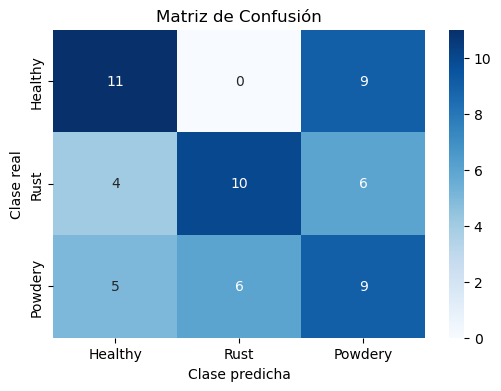


Informe de Clasificación:
              precision    recall  f1-score   support

     Healthy       0.55      0.55      0.55        20
        Rust       0.62      0.50      0.56        20
     Powdery       0.38      0.45      0.41        20

    accuracy                           0.50        60
   macro avg       0.52      0.50      0.50        60
weighted avg       0.52      0.50      0.50        60

Resultados de SVM con LBP:

Imágenes correctamente clasificadas: 110/150
Precisión total: 73.33%
Matriz de Confusión:


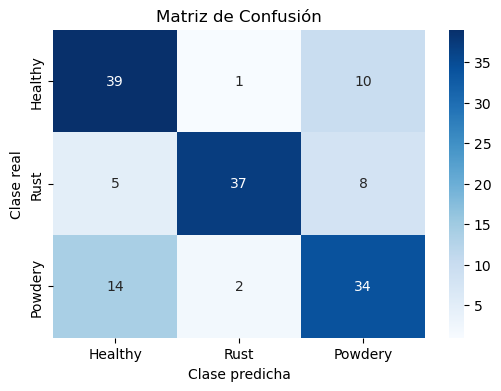


Informe de Clasificación:
              precision    recall  f1-score   support

     Healthy       0.67      0.78      0.72        50
        Rust       0.93      0.74      0.82        50
     Powdery       0.65      0.68      0.67        50

    accuracy                           0.73       150
   macro avg       0.75      0.73      0.74       150
weighted avg       0.75      0.73      0.74       150

Resultados de SVM con LBP-Uniform:

Imágenes correctamente clasificadas: 99/150
Precisión total: 66.00%
Matriz de Confusión:


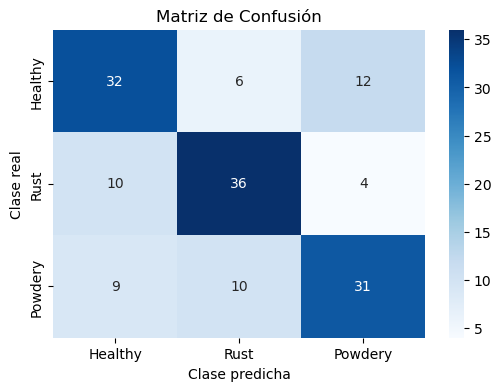


Informe de Clasificación:
              precision    recall  f1-score   support

     Healthy       0.63      0.64      0.63        50
        Rust       0.69      0.72      0.71        50
     Powdery       0.66      0.62      0.64        50

    accuracy                           0.66       150
   macro avg       0.66      0.66      0.66       150
weighted avg       0.66      0.66      0.66       150



In [80]:
results_HOG = evaluate_svm_multiple(mejor_modelo_HOG_multiple, X_test_HOG, y_test_HOG, "HOG", ["Healthy", "Rust", "Powdery"])
results_LBP = evaluate_svm_multiple(mejor_modelo_LBP_multiple, X_test_LBP, y_test_LBP, "LBP", ["Healthy", "Rust", "Powdery"])
results_LBP_uniform = evaluate_svm_multiple(mejor_modelo_LBP_uniform_multiple, X_test_LBP_uniform, y_test_LBP_uniform, "LBP-Uniform", ["Healthy", "Rust", "Powdery"])

In [83]:
import pandas as pd
# Comparación final
results_df = pd.DataFrame([results_HOG, results_LBP, results_LBP_uniform])
print("Comparativa de resultados:")
print(results_df)

Comparativa de resultados:
    Descriptor  Accuracy  Precision Healthy  Recall Healthy  F1-Score Healthy  \
0          HOG  0.500000           0.550000            0.55          0.550000   
1          LBP  0.733333           0.672414            0.78          0.722222   
2  LBP-Uniform  0.660000           0.627451            0.64          0.633663   

   Precision Rust  Recall Rust  F1-Score Rust  Precision Powdery  \
0        0.625000         0.50       0.555556           0.375000   
1        0.925000         0.74       0.822222           0.653846   
2        0.692308         0.72       0.705882           0.659574   

   Recall Powdery  F1-Score Powdery  
0            0.45          0.409091  
1            0.68          0.666667  
2            0.62          0.639175  
